## Stratification of an area of interest - step 1

### Get ALL THE DATA

this notebook will collect spatial data and save them out as a series of geotiffs into a specified directory.

##### It's important to note that there is no pre-processing of the data here. The geotiffs will probably be in different projections, as Sentinel-2 data is stored in UTM. Any processing needed is handled in step 2/notebook 2.

In [15]:
%pip install ipywidgets -q
%pip install --upgrade ipywidgets -q
%pip install spyndex -q
%pip install dask -q
%pip install dask-expr -q
%pip install odc-stac -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [16]:
import os
import json
from io import StringIO
import numpy as np
import xarray as xr
import geopandas as gpd
import shapely.geometry
import rasterio
import rioxarray

from geodata_fetch.harvest import DataHarvester
from gis_utils.dataframe import get_bbox_from_geodf

import spyndex

from rasterio.plot import show
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, interact

import dask.distributed
from dask.diagnostics import ProgressBar
from rasterio.enums import Resampling

from IPython.display import display
from pystac_client import Client
from odc.stac import configure_rio, load #stac_load,
import odc.geo

This notebook is using odc-stac for fetching sentinel-2 data and generating spectral indices. The odc-stac package uses dask, so it has been installed as well. The step below that sets up the dask client is optional, but it does improve load speed for the sentinel-2 data collection.

In [17]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)

/usr/local/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37745 instead
  warnings.warn(
2024-06-25 05:06:20,278 - distributed.scheduler - INFO - State start
2024-06-25 05:06:20,283 - distributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:37735
2024-06-25 05:06:20,284 - distributed.scheduler - INFO -   dashboard at:  http://127.0.0.1:37745/status
2024-06-25 05:06:20,285 - distributed.scheduler - INFO - Registering Worker plugin shuffle
2024-06-25 05:06:20,303 - distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:35689'


2024-06-25 05:06:20,306 - distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:40185'
2024-06-25 05:06:20,311 - distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:36515'
2024-06-25 05:06:20,317 - distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:37511'
2024-06-25 05:06:20,323 - distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:44405'
2024-06-25 05:06:20,951 - distributed.scheduler - INFO - Register worker <WorkerState 'tcp://127.0.0.1:44671', name: 0, status: init, memory: 0, processing: 0>
2024-06-25 05:06:20,955 - distributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:44671
2024-06-25 05:06:20,957 - distributed.core - INFO - Starting established connection to tcp://127.0.0.1:39532
2024-06-25 05:06:20,960 - distributed.scheduler - INFO - Register worker <WorkerState 'tcp://127.0.0.1:38107', name: 1, status: init, memory: 0, processing: 0>
2024-06-25 05:06:20,962 - distributed.scheduler - INFO -

 - `is_valid_pixel` uses the `scl` layer to identify and pixels that are either corrupt, empty, or classified as cloud, aerosols, dust etc. so we can exclude them from the NDVI calculations

In [18]:
def is_valid_pixel(data):
    """
    Check if a pixel value is valid based on the assigned value in the SCL layer

    Parameters:
    data (int): The pixel value to be checked.

    Returns:
    bool: True if the pixel value is valid, False otherwise.
    """

    # include only vegetated, not_vegitated, water, and snow
    return ((data > 3) & (data < 7)) | (data==11)

In [19]:
def plot_geotiff(filename):
    """
    Plot a geotiff file.

    Parameters:
    filename (str): The name of the geotiff file to plot.

    Returns:
    None
    """
    file_path = os.path.join(output_dir, filename)
    with rasterio.open(file_path) as src:
        fig, ax = plt.subplots(figsize=(10, 10))
        show(src, ax=ax, title=filename)
        plt.show()

#### Setup import and export directories, bring in geometry for aoi

 - establish a directory to save the downloaded data to (output_dir)
 - set flags for the data to download - in this case, DEM, SLGA (you need to specify which SLGA layers) and sentinel-2. IF a flag is set to false, that data will not be downloaded

In [20]:
#links to input and output directories
input_dir = "/workspace/notebooks/sandbox/data/stratification"
test_areas_dir = os.path.join(input_dir, "test-areas")

output_dir = "/workspace/notebooks/sandbox/data/stratification/input-rasters"

GET_DEM = True
GET_SLGA = False
GET_SENTINEL = True

Pick the SLGA layers you want to download and put them in the `slga_sources` variable. You need to include both the attribute name (e.g. `Organic_Carbon` as well as the depth layer (`0-5cm`), as you can get data from surface to 2m depth).

Do not edit the DEM inputs. If you do not want DEM, use the flag setting above.

In [24]:
dem_source = {
    "DEM": "DEM",
    "SLGA": {
        "Organic_Carbon": ["0-5cm"]
    }
}


slga_sources = {
    "SLGA": {
        "Organic_Carbon": ["0-5cm"],
        "Bulk_Density": ["0-5cm"]
    }
}


Set the endpoint for the STAC catalog (using Element84's because they are awesome)

Set the start and end date for the Sentinel-2 data to collect.
- It's important to get several months of data, as the final output file will be a median composite of the spectral index. We want to make sure the index represents the average state of the area of interest, not a single snapshot in time that may be influenced by short-term trends like heavy rainfall.

set the resolution - this is optional. If you leave this as 10, the data will be in the default spatial resolution of Sentinel-2, but because the other data layers will be resampled to this resolution in the next notebook, it's a good diea to choose something coarser. Resampling 90m to 10m is a bit of a stretch.

In [1]:
# setup stac for getting veg indices later

stac_url_sentinel = "https://earth-search.aws.element84.com/v1/"
collection_sentinel = "sentinel-2-l2a"

start_date = "2024-04-01"
end_date = "2024-06-01"

resolution = 20

In [22]:
geojson = {
    'body': {
        "type": "FeatureCollection",
        "name": "dissolved-boundaries",
        "crs": {
            "type": "name",
            "properties": {
                "name": "urn:ogc:def:crs:OGC:1.3:CRS84" 
            }
        },
        "features": [
            {
                "type": "Feature",
                "properties": {
                    "fid": 1
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [116.26012130269045, -29.225295369642396],
                            [116.261724812149055, -29.241374854584375],
                            [116.283751968396274, -29.256813692452539],
                            [116.284342735038919, -29.268250184258388],
                            [116.292247755352392, -29.265992437426529],
                            [116.292360282331941, -29.293057573630019],
                            [116.314865678242256, -29.293523728033122],
                            [116.326259034921833, -29.293033039128805],
                            [116.326315298411629, -29.305397680579894],
                            [116.355065941687045, -29.307016748931797],
                            [116.355065941687045, -29.306575187382712],
                            [116.383366477044206, -29.307384715430175],
                            [116.384322956370426, -29.290407813444993],
                            [116.387586238777402, -29.282629879611861],
                            [116.386517232471661, -29.259807919053017],
                            [116.359201308185533, -29.259488866292969],
                            [116.359229439930417, -29.259243440415627],
                            [116.35242155766754, -29.259292525638209],
                            [116.352140240218716, -29.220237788279107],
                            [116.302234524787593, -29.223503148505326],
                            [116.281388901825679, -29.2239696200396],
                            [116.26012130269045, -29.225295369642396]
                        ]
                    ]
                }
            }
        ]
    }
}

Convert the input json to a geopandas geometry and get the bounding box

/tmp/ipykernel_29883/3462533652.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_lon = gdf.centroid.x[0] #approximate centre latitude based on the input geojson - point roughly in the middle
/tmp/ipykernel_29883/3462533652.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_lat = gdf.centroid.y[0]


bbox: [116.26012130269045, -29.307384715430175, 116.3875862387774, -29.220237788279107]


<Axes: >

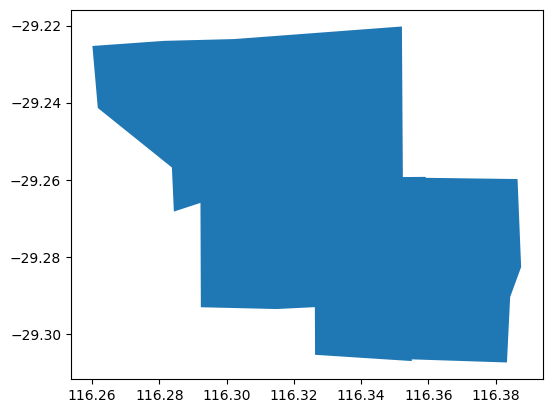

In [23]:
# import geometry for area of interest

req = geojson
geojson_data = req['body']  # Directly accessing the 'body' since it's already a dictionary in this mock setup

# Convert the GeoJSON string to a GeoDataFrame
gdf = gpd.read_file(StringIO(json.dumps(geojson_data)))

geom = gdf.geometry #for data-harvester clip function

bbox = get_bbox_from_geodf(geojson_data)
gdf_lon = gdf.centroid.x[0] #approximate centre latitude based on the input geojson - point roughly in the middle
gdf_lat = gdf.centroid.y[0]

print(f"bbox: {bbox}")

gdf.plot()

#### Set up the json object to be sent to the data harvester

In [25]:
propertyName = "stardew_valley"


data_mask=False #we want the full geotiffs so making the datacube is easier
add_buffer = False
resample=False #we will handle resampling in the pre-processing notebook to maintain consistency.

# Resolution of data download in arcseconds (1 arcsec ~ 30m)
target_res = 1
target_proj = "EPSG:4326" # We will reproject to 3857 later on. This will be more accurate for data collection and pre-processing steps.

date_start = "2022-10-01" #these aren't needed for SLGA but are expected in the package and throw error if excluded - need to fix
date_end = "2022-11-30"
time_intervals = 0 #same issue as above, need to fix in geodata package to be optional.

The data harvester is run separately for the DEM and for SLGA, each within a conditional loop that will run if the associated flag is set to `True`.

In [26]:
if GET_DEM is True:
    json_data = {
        "property_name":propertyName,
        "outpath": output_dir,
        "data_mask": data_mask,
        "target_res": str(target_res),
        "target_crs": target_proj,
        "date_start": date_start if date_start is not None else "2022-10-01", #a date of some kind must be provided or the harvester complains
        "date_end": date_end if date_end is not None else "2022-11-30",
        "target_centroid_lat": gdf_lat,
        "target_centroid_lng": gdf_lon,
        "time_intervals": time_intervals,
        "target_sources": dem_source,
        "target_bbox": bbox,
        "add_buffer": add_buffer,
        "resample": resample
    }

    #do this to check for any inputs that can't be serialised to json
    for key, value in json_data.items():
        if isinstance(value, np.ndarray):
            print(f"Key '{key}' contains an ndarray.")
    data = json.dumps(json_data)

    # Create a file-like object from JSON string
    json_file_like = StringIO(data)
    
    harvester = DataHarvester(json_file_like, geom)
    harvester.run()


Requested the following 2 sources: ['DEM', 'SLGA']
WCS data downloaded and saved as SLGA_Organic_Carbon_0-5cm_stardew_valley.tiff
SLGA data downloaded successfully: ['SLGA_Organic_Carbon_0-5cm_stardew_valley']
/workspace/notebooks/sandbox/data/stratification/input-rasters/DEM_SRTM_1_Second_Hydro_Enforced_stardew_valley.tiff


In [27]:
if GET_SLGA is True:
    json_data = {
        "property_name":propertyName,
        "outpath": output_dir,
        "data_mask": data_mask,
        "target_res": str(target_res),
        "target_crs": target_proj,
        "date_start": date_start if date_start is not None else "2022-10-01", #a date of some kind must be provided or the harvester complains
        "date_end": date_end if date_end is not None else "2022-11-30",
        "target_centroid_lat": gdf_lat,
        "target_centroid_lng": gdf_lon,
        "time_intervals": time_intervals,
        "target_sources": slga_sources,
        "target_bbox": bbox,
        "add_buffer": add_buffer,
        "resample": resample
    }

    #do this to check for any inputs that can't be serialised to json
    for key, value in json_data.items():
        if isinstance(value, np.ndarray):
            print(f"Key '{key}' contains an ndarray.")
    data = json.dumps(json_data)

    # Create a file-like object from JSON string
    json_file_like = StringIO(data)
    
    harvester = DataHarvester(json_file_like, geom)
    harvester.run()

#### Get Sentinel-2 and indices

Collecting Sentinel-2 (or in future, Landsat) is not currently aprt of the geodata pythong package. So instead we use `pystac_client` and `odc-stac` to search for Sentinel-2 data that covers the area of interest, within the timeframe of interest, and then download only the spectral bands needed to calcualte the indices we're interested in.

This notebook uses `odc-stac` instead of `stackstac` as `odc-stac` has better support. It is built and maintained by Goescience Australia, whereas `stackstac` was developed and maintained by a single freelance developer. `odc-stac` is used more within the RSGIS community so we should consider this for our applications for now.

##### Steps this cell performs:
- establish connection to Element84 catalog and select the `[sentinel-2-l2a]` collection. It is important to use the L2A collection as this has been processed to remove atmospheric conditions that affect index calculations over time.
- Use `odc-stac` to "lazily load" the sentinel-2 scenes that cover the bounding box. This only loads the pixels within the bounding box instead of the entire scene (much smaller area) and only downloads the spectral bands we select. The data is loaded to memory as an xarray data array
- creates a val;id pixel mask using the `is_valid_pixel` function
- for each time dimension in the data array, calculate the NDVI. This means for each 'day' we have Sentinel-2 data in the array, we now have an NDVI
- calculate the median NDVI based on the calcualted individual NDVI's.
- save out the median NDVI in the same directory as the DEM and SLGA geotiffs

In [28]:
if GET_SENTINEL is True:
    catalog = Client.open(stac_url_sentinel)

    query = catalog.search(
        collections=["sentinel-2-l2a"],
        datetime=f"{start_date}/{end_date}",
        bbox=bbox
    )

    print(query.item_collection_as_dict())

    for item in query.items_as_dicts():
        print(item['id'])

    #lazily combine
    xx = load(
        query.items(),
        bands = ("red", "nir", "scl"),
        resolution = resolution,
        chunks={}, # use dask
        groupby = "solar_day", #this merges adjacent scenes and de-duplicates overlapping pixels
        bbox = bbox,
        resampling="bilinear"
    )

    xx['valid'] = is_valid_pixel(xx.scl)
    xx = xx/10000

    xx['ndvi'] = (xx.nir - xx.red) / (xx.nir + xx.red)

    ndvi_median = (
        xx['ndvi']
        .where(xx.valid)
        .median(dim="time")
    )


    ndvi_filename = f"NDVI_median_{start_date}_{end_date}_{propertyName}.tiff"
    ndvi_filepath = os.path.join(output_dir, ndvi_filename)
    ndvi_tiff = ndvi_median.odc.write_cog(ndvi_filepath, overwrite=True)


{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'stac_version': '1.0.0', 'id': 'S2A_50JMN_20240530_0_L2A', 'properties': {'created': '2024-05-30T10:26:05.809Z', 'platform': 'sentinel-2a', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'eo:cloud_cover': 53.669029, 'proj:epsg': 32750, 'mgrs:utm_zone': 50, 'mgrs:latitude_band': 'J', 'mgrs:grid_square': 'MN', 'grid:code': 'MGRS-50JMN', 'view:sun_azimuth': 29.3749614495607, 'view:sun_elevation': 32.8036400243239, 's2:degraded_msi_data_percentage': 0.0044, 's2:nodata_pixel_percentage': 0, 's2:saturated_defective_pixel_percentage': 0, 's2:dark_features_percentage': 3e-06, 's2:cloud_shadow_percentage': 0.053318, 's2:vegetation_percentage': 0.0158, 's2:not_vegetated_percentage': 42.969558, 's2:water_percentage': 0.276154, 's2:unclassified_percentage': 3.016135, 's2:medium_proba_clouds_percentage': 10.372023, 's2:high_proba_clouds_percentage': 10.686, 's2:thin_cirrus_percentage': 32.611009, 's2:snow_ice_percentage': 0, 's2

/usr/local/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
